# GADF
In this notebook we will experiment with GADF

## Dependencies
pyts
[https://pypi.org/project/TA-Lib/]("https://pypi.org/project/pyts/")

ta
[https://github.com/bukosabino/ta]("https://github.com/bukosabino/ta")

In [1]:
import pandas as pd
import numpy as np

from dotenv import load_dotenv
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import fastcore.all as fc

from ta import add_all_ta_features
from ta.utils import dropna

from sklearn.preprocessing import RobustScaler, MinMaxScaler

from pyts.image import GramianAngularField

# data util functions
from data import get_data, p2df, zscore_normalize, minmax_normalize, normalize_, create_window

In [2]:
# FOR THIS WE WILL USE THE POLYGON API
load_dotenv()
POLYGON_API_KEY = os.getenv('POLYGON_API_KEY')

In [3]:
# load some data, we will use TSLA
data = get_data(POLYGON_API_KEY, ticker="TSLA", multiplier=1, timespan="day", from_="2021-01-09", to="2023-01-10", limit=5000)

In [4]:
# turn our data into a dataframe
df = p2df(data, convert_timestamp=True) # convert timestamp to datetime

In [5]:
df.head()

,timestamp,open,high,low,close,volume,vwap,transactions
0,2021-02-25 05:00:00,242.0500,245.7355,223.5267,227.4067,117071565.0,233.8999,1292751
1,2021-02-26 05:00:00,233.3333,235.5667,219.8367,225.1667,123267519.0,226.8575,1141064
2,2021-03-01 05:00:00,230.0367,290.6667,228.3500,239.4767,81408606.0,235.6278,820200
3,2021-03-02 05:00:00,239.4267,240.3700,228.3333,228.8133,71196474.0,234.0729,842209
4,2021-03-03 05:00:00,229.3300,233.5667,217.2350,217.7333,90548880.0,225.2051,1046906


In [6]:
# for our GADF we will first add a lot of TA features
# the only features we are interested in are open, high, low, close, volume so lets clear the rest
df = df[['open', 'high', 'low', 'close', 'volume']]
df.head()

,open,high,low,close,volume
0,242.0500,245.7355,223.5267,227.4067,117071565.0
1,233.3333,235.5667,219.8367,225.1667,123267519.0
2,230.0367,290.6667,228.3500,239.4767,81408606.0
3,239.4267,240.3700,228.3333,228.8133,71196474.0
4,229.3300,233.5667,217.2350,217.7333,90548880.0


In [7]:
# lets drop any na values, there shouldnt be any with polgyon data
df = dropna(df)

In [8]:
# lets now add all the ta features
df = add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [9]:
df.head()

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,242.0500,245.7355,223.5267,227.4067,117071565.0,-7.616547e+07,117071565.0,-0.650589,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,227.406700,-12.130716,0.000000,0.000000
1,233.3333,235.5667,219.8367,225.1667,123267519.0,-1.158963e+08,-6195954.0,-0.482220,-2.761192e+08,-88.425128,...,-0.078634,-0.015727,-0.062908,0.420541,0.084108,0.336433,226.384017,-0.985019,-0.989903,-0.985019
2,230.0367,290.6667,228.3500,239.4767,81408606.0,-1.682338e+08,75212652.0,-0.522875,-7.025119e+07,2434.737018,...,0.361559,0.059730,0.301829,-2.144705,-0.361654,-1.783050,231.593859,6.355291,6.161511,5.307671
3,239.4267,240.3700,228.3333,228.8133,71196474.0,-2.337519e+08,4016178.0,-0.594873,-1.686719e+08,-425.307089,...,0.329156,0.113615,0.215540,-4.987459,-1.286815,-3.700644,230.803910,-4.452792,-4.554974,0.618539
4,229.3300,233.5667,217.2350,217.7333,90548880.0,-3.187753e+08,-86532702.0,-0.659317,-2.879019e+08,-161.439634,...,-0.087549,0.073383,-0.160932,-5.807319,-2.190916,-3.616403,227.349884,-4.842376,-4.963547,-4.253788


In [10]:
# let's remove some features
remove = ['trend_psar_up', 'trend_psar_down']
df.drop(columns=remove,axis=1,inplace=True)

In [11]:
window_size = 20
target = df['close'].rolling(window_size).apply(lambda x: (x[-1] - x[0]) / x[0], raw=True).values

In [12]:
# lets scale our data, not including our target
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(df.values)
data_normalized = scaler.transform(df.values)

In [13]:
target.shape, data_normalized.shape

((473,), (473, 89))

In [14]:
from dataclasses import dataclass

In [15]:
class Data:
    def __init__(self, data, target): self.data, self.target = data, target
    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i], self.target[i]

In [16]:
data = Data(data_normalized, target)

In [17]:
def create_window(data, start=0, size=28):
    """Create a window of data"""
    x, y = data[start:start+size]
    return {'data': x, 'target': y[-1]}

In [18]:
window = create_window(data, start=2, size=window_size)
window['data'].shape

(20, 89)

In [19]:
# create window sliding with stride of 1
windows = [create_window(data, start=i, size=window_size) for i in range(len(data)-window_size)]

In [20]:
# create a split of windows to train and test
train_split = int(len(windows) * 0.8)
train_windows = windows[:train_split]
test_windows = windows[train_split:]

In [21]:
gasf = GramianAngularField(image_size=28, method='summation')
gadf = GramianAngularField(image_size=28, method='difference')

In [22]:
# lets create our CNN dataset class
class CNNDataset(Dataset):
    def __init__(self, windows, transform_fn=gasf):
        self.X = [transform_fn.fit_transform(window['data']) for window in windows]
        self.y = [window['target'] for window in windows]

    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float)
        y = torch.tensor(self.y[idx], dtype=torch.float).unsqueeze(0)
        return x, y

In [23]:
from dataclasses import dataclass

In [24]:
@dataclass
class Dls:
    train: DataLoader
    valid: DataLoader

In [25]:
train_ds = CNNDataset(train_windows)
valid_ds = CNNDataset(test_windows)

In [26]:
# create our dataloaders
dls = Dls(
    train = DataLoader(train_ds, batch_size=32, shuffle=True),
    valid = DataLoader(valid_ds, batch_size=32, shuffle=False))

In [27]:
xb, yb = next(iter(dls.train))

In [28]:
xb.shape, yb.shape

(torch.Size([32, 20, 28, 28]), torch.Size([32, 1]))

In [30]:
def_device = "mps" if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(data, device=def_device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)): return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [31]:
class Learner:
    """This is our main class that will be responsible to experimenting and training various models. It serves the purpose of being a vehicle to experiment quickly"""
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD):
        """
        model: <PyTorch Model> the model we are going to train
        dls: <Pytorch DataLoader> the dataloaders we are going to use
        loss_func: <Callable> the loss function we are going to use
        lr: <float> the learning rate we are going to use
        opt_func: <PyTorch optimizer (can be custom)> the optimizer we are going to use
        """
        fc.store_attr() # easy method to store all attributes, prevents mistakes

    def one_batch(self):
        """This method is responsible for one batch of training/evaluation"""
        self.xb, self.yb = to_device(self.batch) # move batch to device
        self.preds = self.model(self.xb) # get predictions
        self.loss = self.loss_func(self.preds, self.yb) # calculate loss
        if self.model.training:
            self.loss.backward() # calculate gradients
            self.opt.step() # update weights
            self.opt.zero_grad() # zero gradients
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        """This method is responsible for calculating statistics"""
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)
    
    def one_epoch(self, train):
        self.model.training = train # set model to training mode or evaluation mode
        dl = self.dls.train if train else self.dls.valid # get the correct dataloader
        for self.num, self.batch in enumerate(dl): 
            self.one_batch() # call one_batch method, self.batch will be set to the current batch
        n = sum(self.ns)
        print(f"Epoch: {self.epoch+1}", 'train' if self.model.training else 'valid', f"Loss: {sum(self.losses).item()/n}")
    
    def fit(self, n_epochs):
        """Very lightweight fit method, this is the highest level to train a model via the Learner object"""
        self.losses, self.ns = [], []
        self.model.to(def_device) # place model on appropriate device TODO: Allow this to be changed via fit calls if necessary
        self.opt = self.opt_func(self.model.parameters(), lr=self.lr) # create optimizer
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True) # training
            self.one_epoch(False) # evaluation

In [53]:
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [344]:
# Let's now create a simple cnn
simple_cnn = nn.Sequential(
    conv(20, 4),
    conv(4, 8),
    conv(8, 16),
    conv(16, 16),
    conv(16, 1, act=False),
    nn.Flatten() # flatten our conv output to feed into a linear layer
)

In [188]:
learn = Learner(simple_cnn, dls, nn.MSELoss(), lr=0.01, opt_func=optim.Adagrad)

In [189]:
learn.fit(20)

Epoch: 1 train Loss: 0.019070199839976612
Epoch: 1 valid Loss: 0.02070929672544366
Epoch: 2 train Loss: 0.014769159796779141
Epoch: 2 valid Loss: 0.01622586850298951
Epoch: 3 train Loss: 0.013073475955036537
Epoch: 3 valid Loss: 0.014218547223156387
Epoch: 4 train Loss: 0.012057661802390507
Epoch: 4 valid Loss: 0.012864465481924431
Epoch: 5 train Loss: 0.011258007740908625
Epoch: 5 valid Loss: 0.01194646300595854
Epoch: 6 train Loss: 0.010722716135083835
Epoch: 6 valid Loss: 0.011252287471004933
Epoch: 7 train Loss: 0.01021028927394322
Epoch: 7 valid Loss: 0.010750221100864031
Epoch: 8 train Loss: 0.009875190922736851
Epoch: 8 valid Loss: 0.010286899591913286
Epoch: 9 train Loss: 0.009530010500925603
Epoch: 9 valid Loss: 0.009857325569098564
Epoch: 10 train Loss: 0.009203324529549431
Epoch: 10 valid Loss: 0.009492800883109996
Epoch: 11 train Loss: 0.008914948289548386
Epoch: 11 valid Loss: 0.009147920403737943
Epoch: 12 train Loss: 0.008651393679840974
Epoch: 12 valid Loss: 0.008998312

In [192]:
# save our model
torch.save(simple_cnn.state_dict(), "simple_cnn_tsla_3.pth")

In [374]:
# load our model
simple_cnn.load_state_dict(torch.load("simple_cnn_tsla.pth"))

<All keys matched successfully>

In [375]:
# let's run some predictions, we will plot the predictions and the actual values
def plot_preds(preds, yb):
    plt.plot(preds, label="preds")
    plt.plot(yb, label="actual")
    plt.legend()

In [376]:
def predict_plot(xb, yb, model):
    # move to device
    xb, yb = to_device(xb), to_device(yb)
    if isinstance(model, nn.Module): model = to_device(model)

    # get predictions
    preds = model(xb)

    # plot predictions
    with torch.no_grad(): plot_preds(preds.squeeze().detach().cpu().numpy(), yb.squeeze().detach().cpu().numpy())

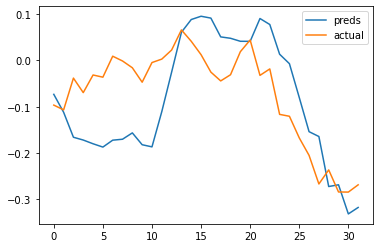

In [377]:
# plot predictions
xb, yb = next(iter(dls.valid))
predict_plot(xb, yb, simple_cnn)

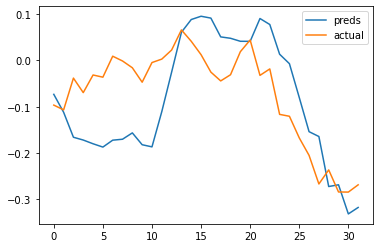

In [378]:
# plot predictions
xb, yb = next(iter(dls.valid))
predict_plot(xb, yb, simple_cnn)

In [193]:
from functools import partial

In [291]:
def load_model(path, cnn):
    # load our model
    cnn.load_state_dict(torch.load(path))
    cnn.eval()
    return cnn

def ensemble(models, xb):
    models = [to_device(m) for m in models]
    outs = 0
    for model in models:
        outs += model(xb)
    return outs/len(models)

In [388]:
model1 = nn.Sequential(conv(20, 4), conv(4, 8), conv(8, 16), conv(16, 16),
    conv(16, 1, act=False), nn.Flatten())
model1.load_state_dict(torch.load("./model_weights/simple_cnn_tsla.pth"))

<All keys matched successfully>

In [380]:
model2 = nn.Sequential(conv(20, 4), conv(4, 8), conv(8, 16), conv(16, 16),
    conv(16, 1, act=False), nn.Flatten())
model2.load_state_dict(torch.load("./model_weights/simple_cnn_tsla_2.pth"))

<All keys matched successfully>

In [381]:
model3 = nn.Sequential(conv(20, 4), conv(4, 8), conv(8, 16), conv(16, 16),
    conv(16, 1, act=False), nn.Flatten())
model3.load_state_dict(torch.load("./model_weights/simple_cnn_tsla_3.pth"))

<All keys matched successfully>

In [400]:
# plot predictions
xb, yb = next(iter(dls.valid))

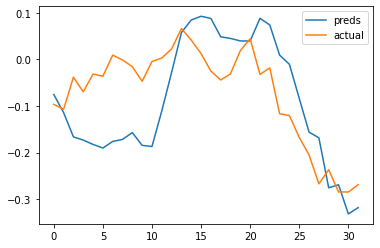

In [401]:
# plot predictions
xb, yb = next(iter(dls.valid))
predict_plot(xb, yb, model1)

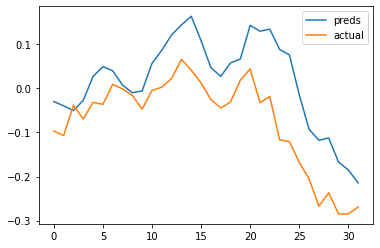

In [402]:
# plot predictions
predict_plot(xb, yb, model2)

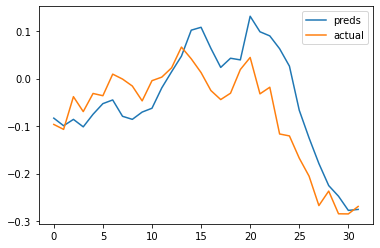

In [403]:
# plot predictions
predict_plot(xb, yb, model3)

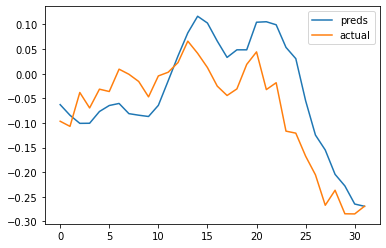

In [408]:
predict_plot(xb, yb, model=partial(ensemble, [model1, model2, model3]))